# Download libraries 

In [2]:
!pip3 install -U --quiet scikit-learn==1.3.2 pandas==2.0.3 matplotlib

In [ ]:
!pip3 install --quiet torch==2.4.0 torchvision torchaudio

Check that the right CUDA and torch versions are installed to ensure compatibility in case of errors: https://pytorch.org/get-started/previous-versions/

In [4]:
%%bash
python -c "import torch; print(torch.__version__)"

2.4.1+cu121


In [5]:
%%bash
python -c "import torch; print(torch.version.cuda)"

12.1


In [6]:
!pip3 install --quiet torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html

In [7]:
!pip3 install --quiet torch-geometric

# Load and prepare all the data

In [8]:
# Import necessary libraries
import os
import sys
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay, 
                             roc_curve, roc_auc_score, RocCurveDisplay, 
                             average_precision_score)

In [9]:
# Define data path and cancer type parameters
cancer_names = ["blca", "brca", "coad", "hnsc", "ucec"]
cancer_type = cancer_names[0]

# Neural network parameters
SEED = 32
n_edges = 267186

In [10]:
# Helper functions to load the node features and save the mapping

def load_node_csv(path, index_col, encoders=None, **kwargs):
    """
    Load node features from a CSV file.

    Parameters:
    - path (str): Path to the CSV file
    - index_col (int): Column to use as the index for the dataframe

    Returns:
    - x (DataFrame): Loaded feature data
    - mapping (dict): Dictionary mapping gene names to indices
    """
    df = pd.read_csv(path, index_col=index_col, header=None)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    x = df.iloc[:, 0:]
    return x, mapping


def save_mapping_json(mapping_file):
    """
    Save gene mapping as a JSON file.

    Parameters:
    - mapping_file (dict): Dictionary mapping gene names to indices
    """
    with open('gene_mapping.json', 'w') as outfile:
        json.dump(mapping_file, outfile)

In [ ]:
def read_files():
    """
    Read data files and create a PyTorch dataset.

    Returns:
    - compact_data (Data): PyTorch Geometric Data object containing gene data
    - driver_ids (DataFrame): Dataframe of driver gene IDs
    - passenger_ids (DataFrame): Dataframe of passenger gene IDs
    - gene_features (DataFrame): Dataframe of gene features
    - mapping (dict): Dictionary mapping gene names to indices
    """
    final_path = os.path.join(cancer_type)
    print(f"Paths used: {final_path}" )
    driver = pd.read_csv(os.path.join(final_path, "drivers"), header=None)
    gene_features = pd.read_csv(os.path.join(final_path, "gene_features"), header=None)
    links = pd.read_csv(os.path.join(final_path, "links"), header=None)
    passengers = pd.read_csv(os.path.join(final_path, "passengers"), header=None)

    

    # Display loaded data for verification
    print("Driver genes:\n", driver.head(), "\n")
    print("Passenger genes:\n", passengers.head(), "\n")
    print("Gene embeddings:\n", gene_features.head(), "\n")
    print("Gene links:\n", links.head(), "\n")

    # Prepare driver and passenger gene lists
    driver_gene_list = driver[0].tolist()
    passenger_gene_list = passengers[0].tolist()

    # Load node features and mapping
    x, mapping = load_node_csv(os.path.join(final_path, "gene_features"), 0)

    # Initialize target labels
    y = torch.zeros(x.shape[0], dtype=torch.long)  # All labels initialized to 0
    y[:] = -1
    driver_ids = driver.replace({0: mapping})
    passenger_ids = passengers.replace({0: mapping})

    # Assign labels: driver = 1, passenger = 0
    y[driver_ids[0].tolist()] = 1
    y[passenger_ids[0].tolist()] = 0

    # Display counts of labeled nodes
    print("Driver genes count:", len([i for i in y if i == 1]))
    print("Passenger genes count:", len([i for i in y if i == 0]))
    print("Unlabeled genes count:", len([i for i in y if i == -1]))

    # Save mapping to JSON
    save_mapping_json(mapping)

    # Process edges and replace gene names with IDs
    links = links.sample(frac=1).iloc[:n_edges]  # Shuffle and limit number of edges
    re_links = links.copy()
    re_links.iloc[:, 0] = links.loc[:, 0].map(mapping)
    re_links.iloc[:, 1] = links.loc[:, 1].map(mapping)
    re_links = re_links.astype({
        0: 'float64',
        1: 'float64',
    })

    # Convert data to appropriate formats for PyTorch
    x = torch.tensor(x.loc[:, 1:].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(re_links.to_numpy(), dtype=torch.long).t().contiguous()

    # Create PyTorch Geometric Data object and assign labels
    compact_data = Data(x=x, edge_index=edge_index)
    compact_data.y = y
    
    return compact_data, driver_ids, passenger_ids, gene_features, mapping

In [ ]:
# Read the files and create the pytoch dataset using the function defined above
compact_data, driver_ids, passenger_ids, gene_features, mapping = read_files()

# Define, train, and evaluate the model

First check the class distribution of our labels

51 51
[-1, 0, 1] [10902, 2303, 51]


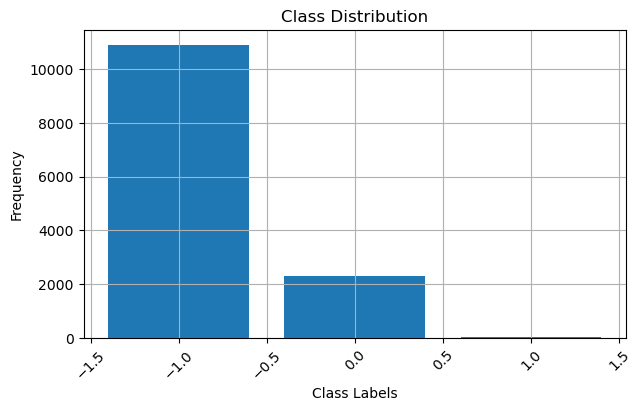

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
"""
Check out the class distribution
"""
def plot_class_distribution(labels):
    print(len([i for i in compact_data.y if i == 1]), len(driver_ids[0].tolist()))
    counter = Counter(labels)
    classes = list(counter.keys())
    counts = list(counter.values())
    print(classes, counts)
    
    # Plotting the distribution
    plt.figure(figsize=(7, 4))
    plt.bar(classes, counts)
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

plot_class_distribution(compact_data.y.numpy())

Next, we will define our models then train and evaluate them. We will also produce plots based on these.

First, define helper functions for plotting our evaluation metrics. Complete the TODOs to create the following plots with `matplotlib`:

1) Precision-recall curve
2) ROC curve
3) Training loss and accuracy across epochs
4) Confusion matrix (TPs, TNs, FPs, FNs)

In [ ]:
# Helper function to plot precision recall curve
def plot_precision_recall(dr_prec, dr_recall, cancer_type, auprc):
    """
    Plot Precision-Recall curve for the model.

    Parameters:
    dr_prec (array): Precision values.
    dr_recall (array): Recall values.
    cancer_type (str): Type of cancer being analyzed.
    auprc (float): Area under the precision-recall curve.
    """
    disp = PrecisionRecallDisplay(precision=dr_prec, recall=dr_recall).plot()
    plt.title(f"Cancer {cancer_type}: Precision-Recall Curve, AUPRC: {np.round(auprc, 2)}")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_roc_curve(fpr, tpr, cancer_type):
    """
    Plot ROC curve for the model.

    Parameters:
    fpr (array): False positive rate values.
    tpr (array): True positive rate values.
    cancer_type (str): Type of cancer being analyzed.
    """
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f"Cancer {cancer_type}: ROC Curve, AUC: {np.round(roc_auc, 2)}")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_loss_accuracy(n_epochs, tr_loss, te_acc, acc_title="Accuracy over Epochs", loss_title="Loss over Epochs"):
    """
    Plot training loss and test accuracy across epochs.

    Parameters:
    n_epochs (int): Number of epochs.
    tr_loss (list): Training loss values.
    te_acc (list): Test accuracy values.
    acc_title (str): Title for accuracy plot.
    loss_title (str): Title for loss plot.
    """
    epochs = np.arange(n_epochs)

    # Plot Training Loss
    plt.plot(epochs, tr_loss, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title(loss_title)
    plt.show()

    # Plot Test Accuracy
    plt.plot(epochs, te_acc, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.title(acc_title)
    plt.show()

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels, classes=['Passengers', 'Drivers']):
    """
    Plot a normalized confusion matrix.

    Parameters:
    true_labels (array): True labels of the data.
    pred_labels (array): Predicted labels from the model.
    classes (list): List of label names.
    """
    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='BuPu', 
               xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Normalized Confusion Matrix")
    plt.show()


Next we will define the HPs used for our model and then define a GCN and GAT model using PyTorch functional as in previous exercises.

In [ ]:
# Define hyperparameters
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold

kfold_re = 10
k_folds = 5
batch_size = 32
num_classes = 2
gene_dim = 12
learning_rate = 0.001
dropout = 0.2

In [ ]:
# Define the GCN model 
class GCN(torch.nn.Module):
    '''
    Neural network with graph convolution network (GCN)
    '''
    def __init__(self):
        super().__init__()
        
        self.conv1 = GCNConv(gene_dim, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 32)
        self.conv4 = GCNConv(32, 16)
        self.conv5 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, p=dropout, training=True)
        h = F.relu(self.conv2(h, edge_index))
        h = F.dropout(h, p=dropout, training=True)
        h = F.relu(self.conv3(h, edge_index))
        h = F.dropout(h, p=dropout, training=True)
        h = F.relu(self.conv4(h, edge_index))
        h = F.dropout(h, p=dropout, training=True)
        return F.log_softmax(self.conv5(h, edge_index), dim=1)

In [ ]:
# Define the GAT model
class GAT(torch.nn.Module):
    '''
    Neural network with graph attention network (GAT)
    '''
    def __init__(self, heads=2, hidden=64):
        super().__init__()        
        self.gat_conv1 = GATConv(gene_dim, hidden, heads=heads)
        self.gat_conv2 = GATConv(hidden*heads, hidden, heads=heads)
        self.gat_conv3 = GATConv(hidden*heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        h = F.relu(self.gat_conv1(x, edge_index))
        h = F.dropout(h, p=dropout, training=True)
        h = F.relu(self.gat_conv2(h, edge_index))
        h = F.dropout(h, p=dropout, training=True)
        return F.log_softmax(self.gat_conv3(h, edge_index), dim=1)

Finally, we define the training helper functions:

1) Train the actual model with backpropagation on the training data
2) Create a boolean mask
3) Sample genes
4) Compute the evaluation metrics

In [ ]:
# Define the training function

def train_model(data, optimizer, model):
    """
    Performs a single training step, including forward pass, 
    loss computation, backpropagation, and optimizer step.
    
    Parameters:
    - data: Input batch data with features, labels, and masks.
    - optimizer: Optimizer for updating model weights.
    - model: The model being trained.
    
    Returns:
    - train_loss: Computed training loss for the batch.
    """
    model.train()
    optimizer.zero_grad()  # Clear previous gradients

    logits = model(data.x, data.edge_index)  # Forward pass
    train_mask = data.batch_train_mask  # Get training mask

    # Compute loss only on training samples
    train_loss = F.nll_loss(logits[train_mask], data.y[train_mask])
    train_loss.backward()  # Backward pass (compute gradients)
    optimizer.step()  # Update model weights

    return train_loss

In [ ]:
# Helper function to create a boolean mask 
def create_masks(total_elements, mask_indices):
    """
    Creates a boolean mask tensor with True values at specified indices.
    
    Parameters:
    - total_elements: Total number of elements in the mask.
    - mask_indices: List of indices to set as True in the mask.
    
    Returns:
    - mask: A boolean tensor with specified indices set to True.
    """
    mask = torch.zeros(total_elements, dtype=torch.bool)
    mask[mask_indices] = True
    return mask

In [ ]:
# Helper function to sample genes 
def sample_genes(gene_set, target_size):
    """
    Samples genes to balance the batch size between classes.
    If the gene set is smaller than the target size, oversampling is applied.
    
    Parameters:
    - gene_set: Array of gene indices for a particular class.
    - target_size: Number of samples required for the batch.
    - batch_size: Total size of the batch.
    - num_classes: Number of classes in the dataset.
    
    Returns:
    - sampled_genes: List of sampled genes for the batch.
    """
    gene_set = np.squeeze(gene_set)

    if len(gene_set) < target_size:
        # Oversample with replacement if fewer genes than needed
        sampled_genes = np.random.choice(gene_set, size=target_size, replace=True).tolist()
    else:
        sampled_genes = gene_set[:batch_size // num_classes]

    return sampled_genes

In [ ]:
# Helper function to compute evaluation metrics
def compute_metrics(model, data, mask_type):
    """
    Evaluates the model and computes various metrics including 
    loss, accuracy, AUPRC, and ROC AUC.
    
    Parameters:
    - model: The trained model to evaluate.
    - data: Input data containing features, labels, and masks.
    - mask_type: Mask type (e.g., test/validation) for evaluation.
    
    Returns:
    - test_loss: Loss computed over the specified mask.
    - test_accuracy: Accuracy on the masked data.
    - test_roc_auc: Area under the ROC curve score.
    - test_auprc: Area under the precision-recall curve.
    - output: Predicted class outputs.
    - logits: Raw model output scores.
    """
    model.eval()  # Set model to evaluation mode
    labels = data.y
    logits = model(data.x, data.edge_index)  # Forward pass

    output = logits.argmax(dim=1)
    test_loss = F.nll_loss(logits[mask_type], labels[mask_type])
    test_accuracy = (output[mask_type] == labels[mask_type]).float().mean()

    # Precision-Recall and ROC Curve calculations
    precision, recall, _ = precision_recall_curve(
        labels[mask_type].cpu().detach().numpy(), 
        logits[mask_type][:, 1].cpu().detach().numpy(), 
        pos_label=1
    )
    test_auprc = auc(recall, precision)

    fpr, tpr, _ = roc_curve(
        labels[mask_type].cpu().numpy(), 
        logits[mask_type][:, 1].cpu().detach().numpy(), 
        pos_label=1
    )
    test_roc_auc = auc(fpr, tpr)

    return test_loss, test_accuracy, test_roc_auc, test_auprc, output, logits

Now we use the helper functions previously defined to implement the final function to train the models with cross-validation and then produce the plots we mentioned previously using the helper functions.

In [ ]:
# Train the model with cross-validation
def create_training_process(compact_data, driver_ids, passenger_ids, gene_features, mapping, weight_decay=0.0005):
    '''
    Initialize network architecture, assign loss functions, optimizers, and create cross-validation pipeline
    '''
    # Initialize model
    model = GCN()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Map gene IDs to integers
    gene_features_ids = gene_features.copy()
    gene_features_ids.iloc[:, 0] = gene_features.loc[:, 0].map(mapping)
    all_gene_ids = gene_features_ids.iloc[:, 0].tolist()
    n_genes = len(all_gene_ids)

    # Balance data size for each class in batches
    equal_size = int(batch_size / float(num_classes))

    # Shuffle and split driver and passenger IDs for training and testing
    driver_ids_list, passenger_ids_list = driver_ids[0].tolist(), passenger_ids[0].tolist()
    random.shuffle(driver_ids_list)
    random.shuffle(passenger_ids_list)
    test_size = 0.33
    test_driver_size = int(test_size * len(driver_ids_list))
    test_passenger_size = int(test_size * len(passenger_ids_list))
    
    test_driver_ids = driver_ids_list[:test_driver_size]
    train_driver_ids = driver_ids_list[test_driver_size:]
    test_passenger_ids = passenger_ids_list[:test_passenger_size]
    train_passenger_ids = passenger_ids_list[test_passenger_size:]
    test_passenger_ids.extend(test_driver_ids)

    # Create test masks
    compact_data.test_mask = create_masks(n_genes, test_passenger_ids)
    train_driver_ids = np.reshape(train_driver_ids, (len(train_driver_ids), 1))
    train_passenger_ids = np.reshape(train_passenger_ids, (len(train_passenger_ids), 1))

    # Initialize performance tracking lists
    metrics_tracking = {
        "train_loss": [], "test_loss": [], "test_accuracy": [],
        "fold_test_loss": [], "fold_test_accuracy": [], "auprc_fold": [],
        "precision_recall": [], "fpr_tpr": [], "final_auprc": []
    }

    compact_data = compact_data.to(device)
    # Set up k-fold cross-validation
    kfold = RepeatedKFold(n_repeats=kfold_re, n_splits=k_folds, random_state=42)
    total_folds = k_folds * kfold_re

    # Cross-validation loop
    for fold, (driver_train_indices, passenger_train_indices) in enumerate(zip(kfold.split(train_driver_ids), kfold.split(train_passenger_ids))):
        
        print(f"Training fold {fold + 1}/{total_folds}")
        # extract training and test IDs for drivers and passengers
        driver_train, driver_test = driver_train_indices
        passenger_train, passenger_test = passenger_train_indices
        num_batches = (len(driver_train) + len(passenger_train) + 1) // batch_size

        # Prepare test genes for the fold
        driver_test_genes = train_driver_ids[driver_test].tolist()
        passenger_test_genes = train_passenger_ids[passenger_test].tolist()
        passenger_test_genes.extend(driver_test_genes)

        # create test mask for evaluation each fold
        compact_data.fold_test_mask = create_masks(n_genes, passenger_test_genes)

        # Batch training loop
        batch_losses = []
        for _ in range(num_batches):
            random.shuffle(driver_train)
            random.shuffle(passenger_train)
            # sample driver and passenger genes
            # driver genes are particularly low in number
            # sample driver and passenger genes uniformly
            batch_driver_genes = sample_genes(train_driver_ids[driver_train], equal_size, )
            batch_passenger_genes = sample_genes(train_passenger_ids[passenger_train], equal_size)

            # concatenate driver and passenger genes to create a training batch
            batch_train_ids = np.concatenate((batch_driver_genes, batch_passenger_genes), axis=0).squeeze()
            # train model on batch training data
            compact_data.batch_train_mask = create_masks(n_genes, batch_train_ids)
            batch_loss = train_model(compact_data, optimizer, model)
            batch_losses.append(batch_loss.cpu().detach().numpy())

        metrics_tracking["train_loss"].append(np.mean(batch_losses))

        # Fold evaluation
        fold_metrics = compute_metrics(model, compact_data, compact_data.fold_test_mask)
        metrics_tracking["fold_test_loss"].append(fold_metrics[0].item())
        metrics_tracking["fold_test_accuracy"].append(fold_metrics[1].item())
        metrics_tracking["auprc_fold"].append(fold_metrics[3])

        print(f"Fold {fold + 1}/{total_folds} - Training Loss: {np.mean(metrics_tracking['train_loss'])}, "
              f"Test Loss: {np.mean(fold_metrics[0].item())}, Test Acc: {np.mean(fold_metrics[1].item())}, "
              f"ROC AUC: {fold_metrics[2]}, AUPRC: {fold_metrics[3]}")

        # Evaluation on unseen data
        unseen_metrics = compute_metrics(model, compact_data, compact_data.test_mask)
        metrics_tracking["test_loss"].append(unseen_metrics[0].item())
        metrics_tracking["test_accuracy"].append(unseen_metrics[1].item())
        print(f"Unseen Data - Test Loss: {unseen_metrics[0].item()}, Test Acc: {unseen_metrics[1].item()}, "
              f"ROC AUC: {unseen_metrics[2]}, AUPRC: {unseen_metrics[3]}")
        print("-------")

    # Final evaluation of unseen data
    print("Final Evaluation on Unseen Test Data")
    print(f"Test AUPRC: {np.mean(metrics_tracking['auprc_fold'])}, "
          f"Loss: {np.mean(metrics_tracking['test_loss'])}, "
          f"Accuracy: {np.mean(metrics_tracking['test_accuracy'])}")
    
    test_mask = compact_data.test_mask
    final_metrics = compute_metrics(model, compact_data, test_mask)
    
    final_precision, final_recall, _ = precision_recall_curve(compact_data.y[test_mask].cpu().detach().numpy(), final_metrics[5][test_mask][:, 1].cpu().detach().numpy(), pos_label=1)
    final_fpr, final_tpr, _ = roc_curve(compact_data.y[test_mask].cpu().detach().numpy(), final_metrics[5][test_mask][:, 1].cpu().detach().numpy(), pos_label=1)
    
    # Plot results
    plot_precision_recall(final_precision, final_recall, cancer_type, fold_metrics[3])
    plot_roc_curve(final_fpr, final_tpr, cancer_type)
    plot_confusion_matrix(compact_data.y[test_mask].cpu().detach().numpy(), final_metrics[4][test_mask].cpu().detach().numpy())
    plot_loss_accuracy(total_folds, metrics_tracking["test_loss"], metrics_tracking["test_accuracy"], "Unseen Data: Accuracy vs Folds", "Unseen Data: Loss vs Folds")
    plot_loss_accuracy(total_folds, metrics_tracking["fold_test_loss"], metrics_tracking["fold_test_accuracy"], "Fold Test: Accuracy vs Folds", "Fold Test: Loss vs Folds")

Training fold 1/50
Fold 1/50 - Training Loss: 0.6481357216835022, Test Loss: 0.7764446139335632, Test Acc: 0.26898735761642456, ROC AUC: 0.9325011558021267, AUPRC: 0.3156471546619711
Unseen Data - Test Loss: 0.785007894039154, Test Acc: 0.22967742383480072, ROC AUC: 0.9039855072463768, AUPRC: 0.3878125059277696
-------
Training fold 2/50
Fold 2/50 - Training Loss: 0.6119288206100464, Test Loss: 0.6676378846168518, Test Acc: 0.4810126721858978, ROC AUC: 0.8562182154415163, AUPRC: 0.1066930168987879
Unseen Data - Test Loss: 0.6742316484451294, Test Acc: 0.5006451606750488, ROC AUC: 0.9105731225296443, AUPRC: 0.29891678592476056
-------
Training fold 3/50
Fold 3/50 - Training Loss: 0.5753743648529053, Test Loss: 0.6145167946815491, Test Acc: 0.5379747152328491, ROC AUC: 0.9542302357836339, AUPRC: 0.19747809380162323
Unseen Data - Test Loss: 0.5977264642715454, Test Acc: 0.584516167640686, ROC AUC: 0.926959815546772, AUPRC: 0.2955063249658989
-------
Training fold 4/50
Fold 4/50 - Training

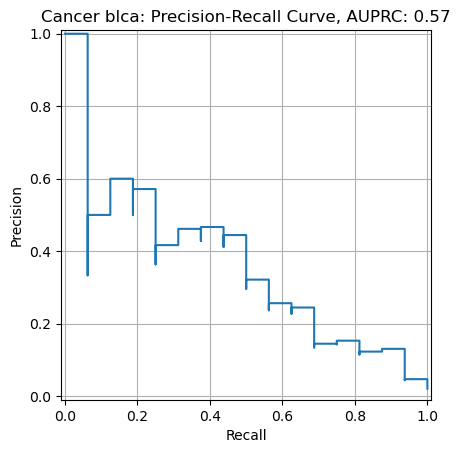

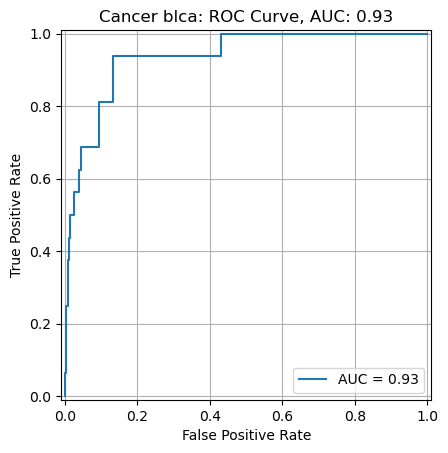

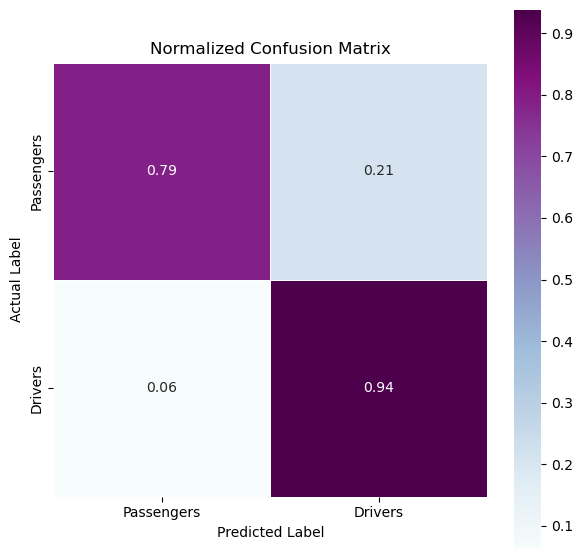

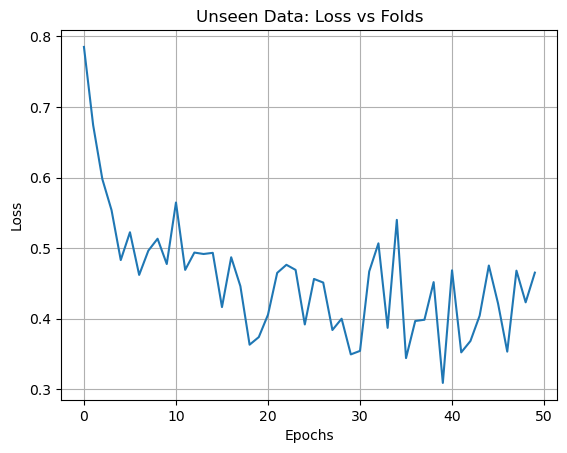

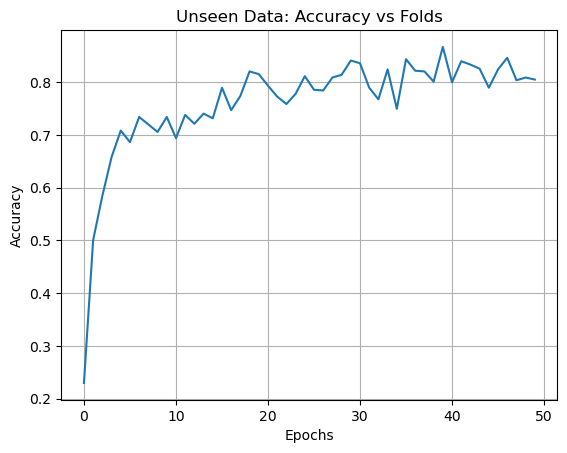

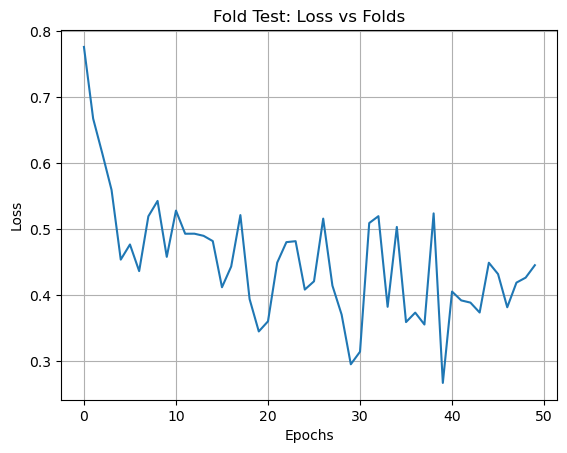

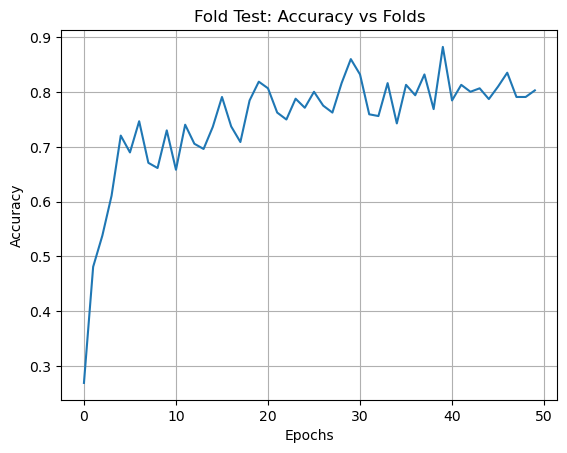

In [ ]:
# Run the training process defined above (includes plotting functions)
create_training_process(compact_data, driver_ids, passenger_ids, gene_features, mapping)

## Further research

- [deepDriver: Predicting Cancer Driver Genes Based on Somatic Mutations Using Deep Convolutional Neural Networks](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2019.00013)
- [Network-based prediction approach for cancer-specific driver missense mutations using a graph neural network](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-023-05507-6)
- [Cancer driver gene discovery in transcriptional regulatory networks using influence maximization approach](https://www.sciencedirect.com/science/article/pii/S0010482519302392)
- [Prediction of Cancer Driver Genes with Graph Neural Networks](https://lume.ufrgs.br/bitstream/handle/10183/261761/001172481.pdf;jsessionid=1816F89F9BED22F569699355E1433355?sequence=1)
- 